## Load data

In [2]:
import os
import pandas as pd
import json
from collections import defaultdict

def filter_only_mixed(moi_dict):

    filtered_dict = defaultdict(dict)

    for sample, allele_dict in moi_dict.items():
        if len(allele_dict) > 1:
            filtered_dict[sample] = allele_dict
    
    return filtered_dict

meta_csv = "../c_parvum_BM_dataset_metadata.csv"
meta_df = pd.read_csv(meta_csv)

with open("../data/filtered_gp60_MOI_0.15_0.075_AF0.05_cov3.json", 'r') as fin:
    jdata = json.load(fin)


host_dict =  {row['name'] : row['Host'] for index, row in meta_df.iterrows()}
geo_dict = {row['name'] : row['continent'] for index, row in meta_df.iterrows()}

host_jdata = defaultdict(dict)
geo_jdata = defaultdict(dict)
cooc_data = {}
for sid, alleles in jdata.items():
    cooc_data[sid] = alleles
    host_jdata[host_dict[sid]][sid] = alleles
    geo_jdata[geo_dict[sid]][sid] = alleles

moi_dict = filter_only_mixed(cooc_data)

host_moi_jdata = defaultdict(dict)
for sid, alleles in moi_dict.items():
    host_moi_jdata[host_dict[sid]][sid] = alleles


## Allele association bubble plot

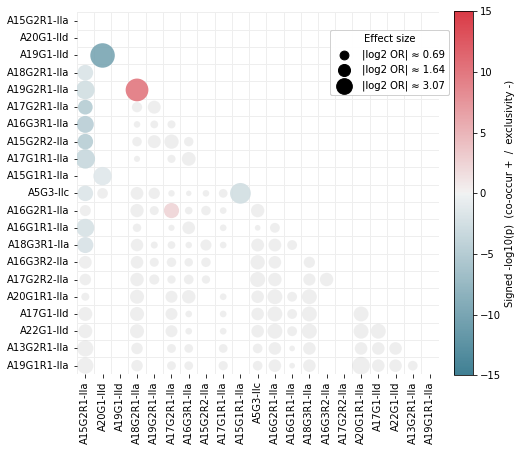

In [3]:
import numpy as np
import pandas as pd
from collections import defaultdict
from itertools import combinations
from statsmodels.stats.contingency_tables import StratifiedTable
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, leaves_list


## ------------------------------------------
## general helper functions
## ------------------------------------------
def presence_sets(jdata):
    return {sid: {r[1] for r in recs if len(r) >= 2 and r[1]}
            for sid, recs in jdata.items()}

def continent_samples(geo_dict, sid2alleles):
    cont2sids = defaultdict(list)
    for sid, cont in geo_dict.items():
        if sid in sid2alleles:
            cont2sids[cont].append(sid)
    return cont2sids

def tables_per_continent(a, b, cont2sids, sid2alleles, min_samples_per_allele=3):
    tables = []
    for _, sids in cont2sids.items():
        S = set(sids)
        if not S: continue
        Sa = {sid for sid in S if a in sid2alleles[sid]}
        Sb = {sid for sid in S if b in sid2alleles[sid]}
        na, nb = len(Sa), len(Sb)
        if na < min_samples_per_allele or nb < min_samples_per_allele:
            continue
        co = len(Sa & Sb)
        a11 = co
        a10 = na - co
        a01 = nb - co
        a00 = len(S) - na - nb + co
        if min(a11, a10, a01, a00) < 0:
            continue
        T = np.array([[a11, a10],
                      [a01, a00]], dtype=float)
        tables.append(T)
    return tables

def any_zero_cell(tables):
    if not tables: return False
    return any((t == 0).any() for t in tables)


## ------------------------------------------
## CMH with p-floor + correction
## ------------------------------------------
def cmh_signed_association(jdata, geo_dict,
                           min_samples_per_allele=3,
                           min_continents=1,
                           p_floor=1e-10,         ## floor p to avoid crazy -log10
                           force_correction=None
                           ):
    sid2alleles = presence_sets(jdata)
    cont2sids = continent_samples(geo_dict, sid2alleles)

    all_alleles = sorted({a for S in sid2alleles.values() for a in S})
    recs = []

    for a, b in combinations(all_alleles, 2):
        tables = tables_per_continent(a, b, cont2sids, sid2alleles, min_samples_per_allele)
        if len(tables) < min_continents:
            continue

        ## continuity correction
        do_corr = (force_correction is True) or (force_correction is None and any_zero_cell(tables))
        if do_corr:
            tables = [t + 0.5 for t in tables]

        ## CMH
        try:
            st = StratifiedTable(tables)
        except Exception:
            # last-ditch: always correct
            tables = [t + 0.5 for t in tables]
            st = StratifiedTable(tables)

        or_cmh = float(st.oddsratio_pooled)
        p_two = float(st.test_null_odds(1).pvalue)

        if or_cmh > 1:
            sign = 1
            p_one = p_two / 2.0
        elif or_cmh < 1:
            sign = -1
            p_one = p_two / 2.0
        else:
            sign = 0
            p_one = 1.0

        ## floor p and score
        p_one = max(p_one, p_floor)
        score = sign * (-np.log10(p_one))

        recs.append({
            "allele1": a, "allele2": b,
            "n_continents": len(tables),
            "or_cmh": or_cmh,
            "p_one_sided": p_one,
            "score": score
        })

    stats_df = pd.DataFrame.from_records(recs)
    if stats_df.empty:
        return stats_df, pd.DataFrame()

    ## BH-FDR on floored p's
    stats_df["qval"] = multipletests(stats_df["p_one_sided"].values, method="fdr_bh")[1]

    ## symmetric score matrix
    alleles = sorted(set(stats_df["allele1"]) | set(stats_df["allele2"]))
    score_mat = pd.DataFrame(0.0, index=alleles, columns=alleles, dtype=float)
    for _, r in stats_df.iterrows():
        a, b, s = r["allele1"], r["allele2"], float(r["score"])
        score_mat.loc[a, b] = s
        score_mat.loc[b, a] = s
    np.fill_diagonal(score_mat.values, 0.0)

    stats_df = stats_df.sort_values("score", key=lambda x: np.abs(x), ascending=False).reset_index(drop=True)
    return stats_df, score_mat

## ------------------------------------------
## Clustering order
## ------------------------------------------
def order_by_clustering(score_mat, method="average", metric="euclidean"):
    M = score_mat.replace([np.inf, -np.inf], np.nan).fillna(0.0).astype(float)
    np.fill_diagonal(M.values, 0.0)
    M = (M + M.T) / 2.0
    D = pdist(M.values, metric=metric)
    if np.allclose(D, 0):
        return list(M.index)
    Z = linkage(D, method=method)
    return list(M.index[leaves_list(Z)])


## ------------------------------------------
## Bubble heatmap with clipping
## ------------------------------------------
def bubble_association_with_nonsig(stats_df, alleles_order=None,
                                   alpha=0.05, use_fdr=False,
                                   min_area=30, max_area=600,
                                   max_abs_log10p=15.0
                                   ):
    if stats_df.empty:
        raise ValueError("No allele pairs to plot.")

    alleles = (alleles_order if alleles_order is not None
               else sorted(set(stats_df["allele1"]) | set(stats_df["allele2"])))
    
    M_eff   = pd.DataFrame(np.nan, index=alleles, columns=alleles, dtype=float)   ## log2 OR
    M_score = pd.DataFrame(np.nan, index=alleles, columns=alleles, dtype=float)   ## signed -log10 p (floored)
    M_sig   = pd.DataFrame(False,   index=alleles, columns=alleles)

    df = stats_df.copy()
    sig_mask = (df["qval"] < alpha) if use_fdr else (df["p_one_sided"] < alpha)

    for i, r in df.iterrows():
        a, b = r["allele1"], r["allele2"]
        if np.isfinite(r["or_cmh"]) and r["or_cmh"] > 0:
            v = np.log2(r["or_cmh"])
            M_eff.loc[a, b] = v; M_eff.loc[b, a] = v
        s = r["score"]
        if np.isfinite(s):
            ## clip signed -log10 p
            ## ensure colours are stabled and dont misbehave
            s = float(np.clip(s, -max_abs_log10p, max_abs_log10p))
            M_score.loc[a, b] = s; M_score.loc[b, a] = s
        M_sig.loc[a, b] = bool(sig_mask.loc[i]); M_sig.loc[b, a] = bool(sig_mask.loc[i])

    np.fill_diagonal(M_eff.values, 0.0)
    np.fill_diagonal(M_score.values, 0.0)

    n = len(alleles)
    tril = np.tril_indices(n, k=-1)

    xs, ys, sizes, colors, alphas = [], [], [], [], []
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    norm = mpl.colors.TwoSlopeNorm(vmin=-max_abs_log10p, vcenter=0.0, vmax=max_abs_log10p)

    eff_vals = np.abs(M_eff.values[tril])
    eff_vals = eff_vals[np.isfinite(eff_vals) & (eff_vals > 0)]
    e_min, e_max = (eff_vals.min(), eff_vals.max()) if eff_vals.size else (0.0, 1.0)

    def size_from_eff(e):
        e = abs(e)
        if e <= 0 or not np.isfinite(e): return np.nan
        if e_max == e_min: return 0.5*(min_area+max_area)
        return min_area + (max_area - min_area) * (e - e_min) / (e_max - e_min)

    for i in range(n):
        for j in range(i):
            eff = M_eff.iat[i, j]
            if not np.isfinite(eff) or eff == 0: 
                continue
            xs.append(j + 0.5); ys.append(i + 0.5)
            sizes.append(size_from_eff(eff))
            if M_sig.iat[i, j]:
                colors.append(M_score.iat[i, j]); alphas.append(0.9)
            else:
                colors.append(0.0);               alphas.append(0.25)

    if not xs:
        raise ValueError("Nothing to plot (after filters/clipping).")

    fig, ax = plt.subplots(figsize=(max(6, 0.35*n), max(6, 0.35*n)))
    sns.heatmap(np.zeros((n, n)), cmap="Greys", vmin=0, vmax=1,
                cbar=False, square=True, linewidths=0.5, linecolor="#eeeeee",
                xticklabels=alleles, yticklabels=alleles, ax=ax)

    xs = np.array(xs); ys = np.array(ys); sizes = np.array(sizes)
    colors = np.array(colors); alphas = np.array(alphas)
    is_sig = alphas > 0.5

    ax.scatter(xs[~is_sig], ys[~is_sig], s=sizes[~is_sig],
               c="#bfbfbf", alpha=alphas[~is_sig], edgecolors="none")
    sc = ax.scatter(xs[is_sig], ys[is_sig], s=sizes[is_sig],
                    c=colors[is_sig], cmap=cmap, norm=norm, alpha=alphas[is_sig],
                    edgecolors="none")

    ax.set_xlim(0, n); ax.set_ylim(n, 0)
    ax.set_xticks(np.arange(n)+0.5); ax.set_yticks(np.arange(n)+0.5)
    ax.set_xticklabels(alleles, rotation=90); ax.set_yticklabels(alleles)
    
    ## bubble size legend
    for pct in [25, 50, 90]:
        pass
    
    ## dummy handles for a clean legend
    ptiles = np.percentile(eff_vals, [25, 50, 90])
    handles = []
    labels = []
    for v in ptiles:
        a = min_area + (max_area - min_area) * (v - e_min) / (e_max - e_min + 1e-12)
        h = plt.scatter([], [], s=a, c="k")
        handles.append(h)
        labels.append(f"|log2 OR| ≈ {v:.2f}")
    leg = ax.legend(handles, labels, title="Effect size", loc="upper left",
                    bbox_to_anchor=(0.7, 0.95), borderaxespad=0.)
    ax.add_artist(leg)

    cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Signed -log10(p)  (co-occur +  /  exclusivity -)")
    # ax.set_title("Association (continent-conditioned): color = signed -log10(p), size = |log2 OR|, grey = non-significant")
    # ax.set_title("Continent-conditioned Allele Association")
    plt.tight_layout()
    # plt.savefig("./allele_cooc_CMH.png", dpi=300, bbox_inches='tight', )
    plt.show()
    return ax


## ------------------------------------------
## run
## ------------------------------------------
stats_both, score_mat = cmh_signed_association(
    jdata, geo_dict,
    min_samples_per_allele=3,
    min_continents=1,
    p_floor=1e-10,
    force_correction=None
)
allele_order = order_by_clustering(score_mat)
ax = bubble_association_with_nonsig(stats_both, alleles_order=allele_order,
                                    alpha=0.05, use_fdr=False,
                                    max_abs_log10p=15.0)


## CMH summary table

In [6]:
import numpy as np
import pandas as pd

def cmh_summary_tables(stats_df, alpha=0.05, fdr_alpha=0.05, top_k=25):
    if stats_df.empty:
        raise ValueError("stats_df is empty")

    df = stats_df.copy()
    ## effect direction and size
    df["log2_or"] = np.log2(df["or_cmh"])
    df["direction"] = np.where(df["or_cmh"] > 1, "co-occur",
                        np.where(df["or_cmh"] < 1, "exclusive", "neutral"))

    disp_cols = [
        "allele1", "allele2", "direction", "n_continents",
        "or_cmh", "log2_or", "p_one_sided", "qval", "score"
    ]
    tbl_all = (df[disp_cols]
               .sort_values(["qval","p_one_sided"], ascending=[True, True])
               .reset_index(drop=True))

    p_sig = df["p_one_sided"] < alpha
    q_sig = df["qval"] < fdr_alpha
    counts = {
        "n_pairs_tested": int(len(df)),
        "alpha": alpha,
        "fdr_alpha": fdr_alpha,
        "n_sig_p": int(p_sig.sum()),
        "n_sig_q": int(q_sig.sum()),
        "n_sig_p_cooccur": int((p_sig & (df["or_cmh"] > 1)).sum()),
        "n_sig_p_exclusive": int((p_sig & (df["or_cmh"] < 1)).sum()),
        "n_sig_q_cooccur": int((q_sig & (df["or_cmh"] > 1)).sum()),
        "n_sig_q_exclusive": int((q_sig & (df["or_cmh"] < 1)).sum()),
    }

    tbl_top_p = (tbl_all.sort_values("p_one_sided").head(top_k)
                 .reset_index(drop=True))
    tbl_top_q = (tbl_all.sort_values("qval").head(top_k)
                 .reset_index(drop=True))

    return counts, tbl_all, tbl_top_p, tbl_top_q

counts, tbl_all, tbl_top_p, tbl_top_q = cmh_summary_tables(stats_both, alpha=0.05, fdr_alpha=0.05, top_k=20)

print("Counts:", counts)
tbl_all.to_csv("../data/cmh_allele_association_table.csv", index=False)


Counts: {'n_pairs_tested': 129, 'alpha': 0.05, 'fdr_alpha': 0.05, 'n_sig_p': 14, 'n_sig_q': 8, 'n_sig_p_cooccur': 2, 'n_sig_p_exclusive': 12, 'n_sig_q_cooccur': 1, 'n_sig_q_exclusive': 7}
